### Carregando as bibliotecas e configurações

In [1]:
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
import locale

In [2]:
# Criando o caminho relativo da pasta com os arquivos JSON e capturando o nome dos arquivos
data_dir_caminho = Path('..') / 'data'
arquivos_json = [arq for arq in os.listdir(data_dir_caminho) if arq.endswith('.json')]

# Configurar locale para usar ponto como separador de milhar nos gráficos
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

'pt_BR.UTF-8'

Notebook Color Scheme: 


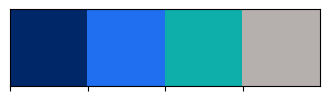

In [3]:
# color scheme
class clr:
    S = '\033[1m' + '\033[96m'
    E = '\033[0m'
    
my_colors = ['#002768', '#1F6FF0', '#0eafaa', '#B5B0AE']
sns.palplot(sns.color_palette(my_colors))
print(clr.S + "Notebook Color Scheme: " + clr.E)

Ao responder as perguntas do time de negócio, além das consultas, plotarei gráficos para uma abordagem visual intuitiva para análise de dados.

Para evitar repetição no código, criei uma classe para plotar gráficos porque isso organiza o código em um único lugar, facilita a reutilização, centraliza ajustes de estilo e melhora a manutenção. Assim, evito repetição de código e deixo a estrutura mais limpa e clara para leitura.

In [4]:
from plot_config import configure_plot_style, PlotUtils
# Configurações globais de estilo para exibição no notebook
configure_plot_style()
%matplotlib inline

# Instanciando a classe
plotutils = PlotUtils()

### Carregando os datasets

In [5]:
# Carrega e concatena (parâmetro lines=True para evitar o aviso de Warning - lê cada linha como um objeto JSON separado)
dfs = []
for arquivo in arquivos_json:
    caminho = os.path.join(data_dir_caminho, arquivo)
    df = pd.read_json(caminho, lines=True)
    dfs.append(df)

df_final = pd.concat(dfs, ignore_index=True)

In [6]:
print("O dataset tem " + str(df_final.shape[0]) + " observações (compras realizadas) e " + str(df_final.shape[1]) + " colunas: " + str([col for col in df_final.columns]))
df_final

O dataset tem 550068 observações (compras realizadas) e 7 colunas: ['usuario', 'produto', 'genero', 'idade', 'produto_categoria', 'valor', 'estado_civil']


,usuario,produto,genero,idade,produto_categoria,valor,estado_civil
0,1000001,P00069042,F,0-17,3,8370,0
1,1000001,P00248942,F,0-17,1,15200,0
2,1000001,P00087842,F,0-17,12,1422,0
3,1000001,P00085442,F,0-17,12,1057,0
4,1000002,P00285442,M,55+,8,7969,0
...,...,...,...,...,...,...,...
550063,1006033,P00372445,M,51-55,20,368,1
550064,1006035,P00375436,F,26-35,20,371,0
550065,1006036,P00375436,F,26-35,20,137,1
550066,1006038,P00375436,F,55+,20,365,0


In [7]:
# trocando o nome da variável para melhorar a legibilidade do código
df = df_final.copy()

In [8]:
## Fazendo algumas transformações necessárias
# Converter a coluna usuario para string
df['usuario'] = df['usuario'].astype('object')

# Transformações de valores dentro da coluna estado_civil
map_estado_civil = {0: "Solteiro", 1: "Casado"}
df['estado_civil'] = df['estado_civil'].map(map_estado_civil)
df['estado_civil'] = df['estado_civil'].astype('category')

# Transformações de valores dentro da coluna genero
map_genero = {"M": "Masculino", "F": "Feminino"}
df['genero'] = df['genero'].map(map_genero)
df['genero'] = df['genero'].astype('category')

# Definir a coluna idade como categórica e com ordem para faixas etárias
ordem_idades = ['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']
df['idade'] = pd.Categorical(df['idade'], categories=ordem_idades, ordered=True)

# Definir a coluna produto_categoria como categorica
df['produto_categoria'] = df['produto_categoria'].astype('category')

## Etapa 1 - Consultas do time de negócio
Além do código desenvolvido para as consultas, foi disponibilizado uma abordagem visual intuitiva para análise de dados. As casas decimais foram omitidas para facilitar a compreensão dos números.


### 1 - Qual o ticket médio das vendas por idade ordenado por idade?

In [9]:
ticket_medio_por_idade = (
    df
    .groupby('idade', observed=False)['valor'] # idade como categorica
    .mean()
    .astype(int)
    .reset_index()
    .sort_values('idade')
    .rename(columns={'valor': 'ticket_medio'})
)

ticket_medio_por_idade

,idade,ticket_medio
0,0-17,8933
1,18-25,9169
2,26-35,9252
3,36-45,9331
4,46-50,9208
5,51-55,9534
6,55+,9336


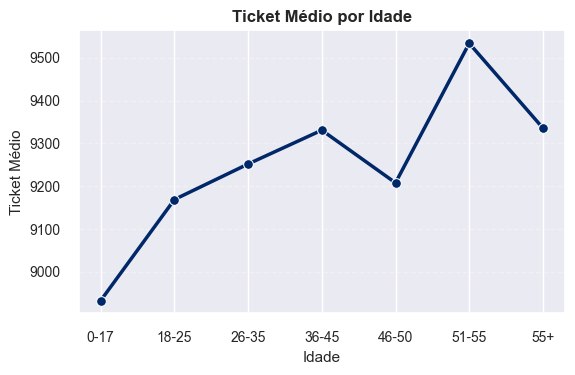

In [10]:
# Gráfico de linha
plotutils.line_plot(
    data=ticket_medio_por_idade,
    x='idade',
    y='ticket_medio',
    title='Ticket Médio por Idade',
    xlabel='Idade',
    ylabel='Ticket Médio',
)

Embora o gráfico pareça que tenha uma grande diferença entre os grupos de idade, os valores estão variando entre cerca de 9 a 9,5 mil. Então globalmente a diferença não é tão significativa.


### 2 - Qual o total de vendas por idade ordenado pelo valor total de vendas?

In [11]:
total_vendas_por_idade = (
    df.groupby('idade', observed=True)['valor']
    .sum()
    .reset_index()
    .rename(columns={'valor': 'total_vendas'})
    .sort_values('total_vendas', ascending=False)
)

total_vendas_por_idade['valor_total_bilhoes'] = total_vendas_por_idade['total_vendas'] / 1_000_000_000
total_vendas_por_idade

,idade,total_vendas,valor_total_bilhoes
2,26-35,2031770578,2.031771
3,36-45,1026569884,1.026570
1,18-25,913848675,0.913849
4,46-50,420843403,0.420843
5,51-55,367099644,0.367100
6,55+,200767375,0.200767
0,0-17,134913183,0.134913


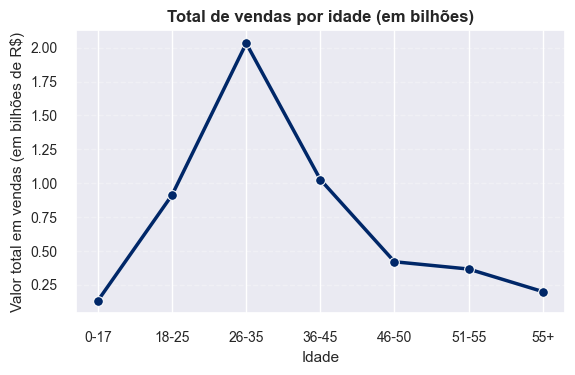

In [12]:
# Gráfico de linha
plotutils.line_plot(
    data=total_vendas_por_idade,
    x='idade',
    y='valor_total_bilhoes',
    title='Total de vendas por idade (em bilhões)',
    xlabel='Idade',
    ylabel='Valor total em vendas (em bilhões de R$)'
)

### 3 - Liste a quantidade dos 10 produtos mais vendidos 

In [13]:
top_10_produtos = (
    df['produto'].value_counts()
    .head(10)
    .reset_index()
    .rename(columns={'count': 'quantidade_vendida'})
)
top_10_produtos

,produto,quantidade_vendida
0,P00265242,1880
1,P00025442,1615
2,P00110742,1612
3,P00112142,1562
4,P00057642,1470
5,P00184942,1440
6,P00046742,1438
7,P00058042,1422
8,P00059442,1406
9,P00145042,1406


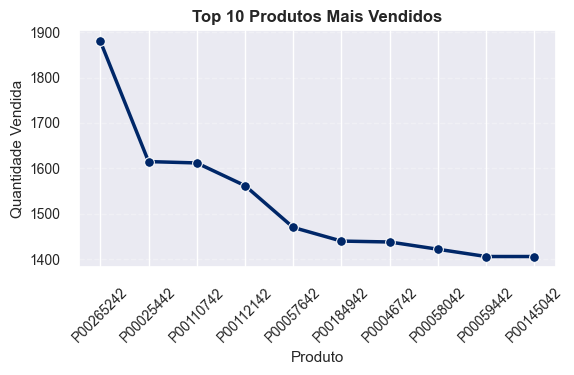

In [14]:
# Gráfico de linha
plotutils.line_plot(
    data=top_10_produtos,
    x='produto',
    y='quantidade_vendida',
    title='Top 10 Produtos Mais Vendidos',
    xlabel='Produto',
    ylabel='Quantidade Vendida',
    rotation=45
)

### 4 - Quantos usuários únicos existem na base?

In [15]:
# usuários distintos na base
num_usuarios_unicos = df['usuario'].nunique()
print(f"Número de usuários únicos na base: {num_usuarios_unicos}")

Número de usuários únicos na base: 5891


### 5 - Liste os 10 usuários com o maior valor total de vendas

In [16]:
# Agrupa por usuário, soma o valor e ordena do maior para o menor
top_10_usuarios = (
    df.groupby('usuario')['valor']
    .sum()
    .reset_index()
    .assign(usuario=lambda x: x['usuario'].astype('object'))
    .rename(columns={'valor': 'valor_total'})
    .sort_values('valor_total', ascending=False)
    .head(10)
)

top_10_usuarios['valor_total_milhoes'] = top_10_usuarios['valor_total'] / 1_000_000
top_10_usuarios

,usuario,valor_total,valor_total_milhoes
4166,1004277,10536909,10.536909
1634,1001680,8699596,8.699596
2831,1002909,7577756,7.577756
1885,1001941,6817493,6.817493
416,1000424,6573609,6.573609
4335,1004448,6566245,6.566245
5683,1005831,6512433,6.512433
981,1001015,6511314,6.511314
3297,1003391,6477160,6.477160
1142,1001181,6387961,6.387961


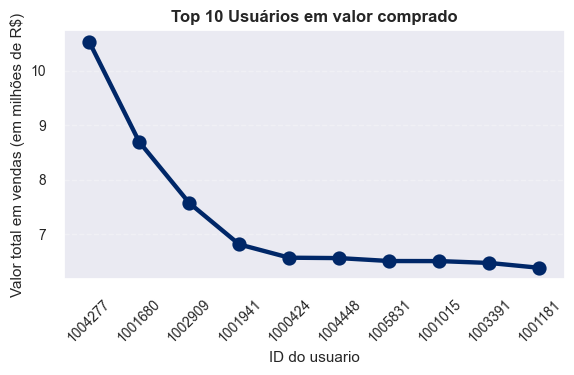

In [17]:
# Gráfico de linha
plotutils.point_plot(
    data=top_10_usuarios,
    x='usuario',
    y='valor_total_milhoes',
    title='Top 10 Usuários em valor comprado',
    xlabel='ID do usuario',
    ylabel='Valor total em vendas (em milhões de R$)',
    rotation=45,
    sort_by_y=True
)

### 6 - Qual porcentagem representa cada faixa etária da base de usuários únicos?

In [18]:
# Usuários únicos por faixa etária
usuarios_por_idade = (
    df.drop_duplicates(subset='usuario')
    ['idade'].value_counts(normalize=True, sort=False)  # sort=False para manter a ordem categórica
    .mul(100)
    .round(2)
    .reset_index()
)
usuarios_por_idade

,idade,proportion
0,0-17,3.70
1,18-25,18.15
2,26-35,34.85
3,36-45,19.81
4,46-50,9.01
5,51-55,8.16
6,55+,6.31


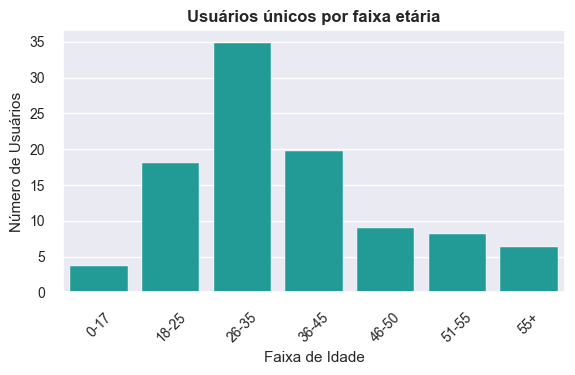

In [19]:
plotutils.bar_plot(
    data=usuarios_por_idade,
    x='idade',
    y='proportion',
    title='Usuários únicos por faixa etária',
    xlabel='Faixa de Idade',
    ylabel='Número de Usuários'
)

# ETAPA 2

### 1 - A empresa precisa identificar qual o público que teve mais alcance na Black Friday, para que no próximo ano tenha uma campanha mais direcionada. Considerando o ticket médio como resultado, faça uma análise e descreva qual ou quais as variáveis mais importantes.

### Estado Civil

In [20]:
# Estado Civil
ticket_medio_por_estado_civil = (
    df
    .groupby('estado_civil', observed=False)['valor']
    .mean()
    .astype(int)
    .reset_index()
    .sort_values('estado_civil')
    .rename(columns={'valor': 'ticket_medio'})
)
ticket_medio_por_estado_civil

,estado_civil,ticket_medio
0,Casado,9261
1,Solteiro,9265


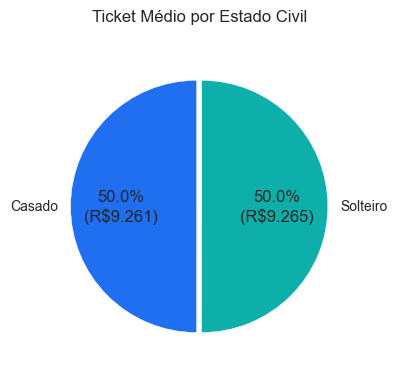

In [21]:
plotutils.pie_chart(
    data=ticket_medio_por_estado_civil.set_index('estado_civil')['ticket_medio'],
    title='Ticket Médio por Estado Civil'
)

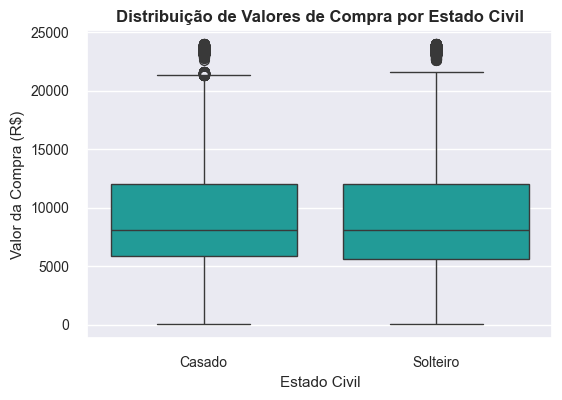

In [22]:
plotutils.box_plot(
    data=df,
    x='estado_civil',
    y='valor',
    title='Distribuição de Valores de Compra por Estado Civil',
    xlabel='Estado Civil',
    ylabel='Valor da Compra (R$)'
)

### Gênero

In [23]:
# Genero
ticket_medio_por_genero = (
    df
    .groupby('genero', observed=False)['valor']
    .mean()
    .astype(int)
    .reset_index()
    .sort_values('valor', ascending=False)
    .rename(columns={'valor': 'ticket_medio'})
)
ticket_medio_por_genero

,genero,ticket_medio
1,Masculino,9437
0,Feminino,8734


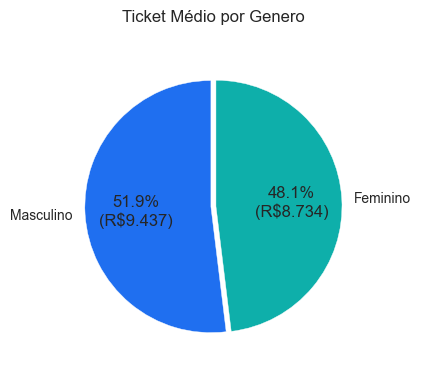

In [24]:
plotutils.pie_chart(
    data=ticket_medio_por_genero.set_index('genero')['ticket_medio'],
    title='Ticket Médio por Genero'
)

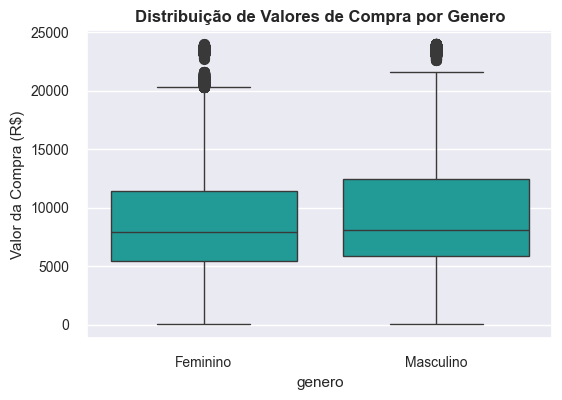

In [25]:
plotutils.box_plot(
    data=df,
    x='genero',
    y='valor',
    title='Distribuição de Valores de Compra por Genero',
    xlabel='genero',
    ylabel='Valor da Compra (R$)'
)

### Idade

In [26]:
# reaproveitando o cálculo feito na pergunta 1 da etapa anterior
ticket_medio_por_idade

,idade,ticket_medio
0,0-17,8933
1,18-25,9169
2,26-35,9252
3,36-45,9331
4,46-50,9208
5,51-55,9534
6,55+,9336


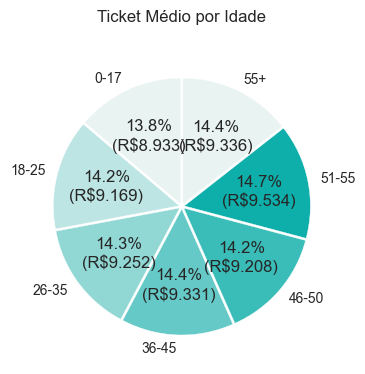

In [27]:
plotutils.pie_chart(
    data=ticket_medio_por_idade.set_index('idade')['ticket_medio'],
    title='Ticket Médio por Idade',
    colors=sns.color_palette("light:#0eafaa")
)

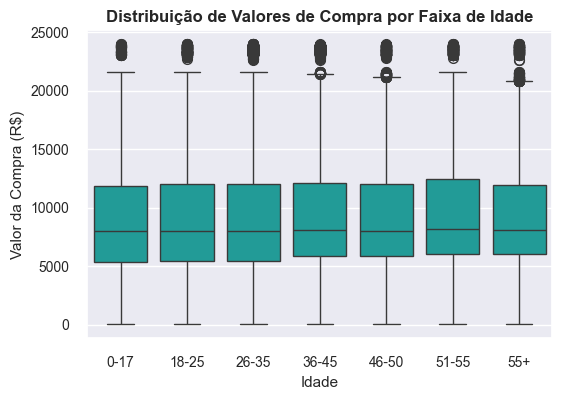

In [28]:
plotutils.box_plot(
    data=df,
    x='idade',
    y='valor',
    title='Distribuição de Valores de Compra por Faixa de Idade',
    xlabel='Idade',
    ylabel='Valor da Compra (R$)'
)

### Produto (Top10)

In [29]:
ticket_medio_por_produto_top10 = (
    df
    .groupby('produto', observed=False)['valor']
    .mean()
    .astype(int)
    .reset_index()
    .sort_values('valor', ascending=False)
    .head(10)
    .rename(columns={'valor': 'ticket_medio'})
)
ticket_medio_por_produto_top10

,produto,ticket_medio
836,P00086242,21256
827,P00085342,20980
1902,P00200642,20468
1070,P00116142,20463
1102,P00119342,20448
1085,P00117642,20400
726,P00074542,20323
3275,P00341542,20291
519,P00052842,20141
844,P00087042,20113


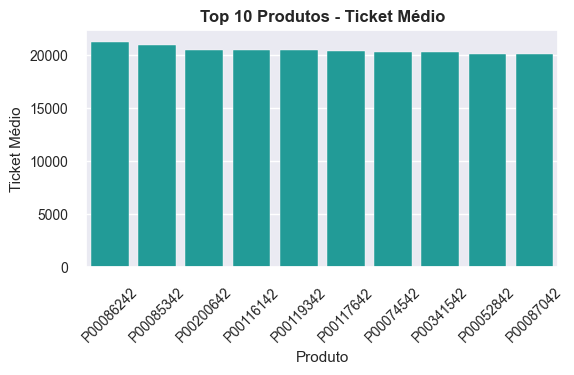

In [30]:
plotutils.bar_plot(
    data=ticket_medio_por_produto_top10,
    x='produto',
    y='ticket_medio',
    title='Top 10 Produtos - Ticket Médio',
    xlabel='Produto',
    ylabel='Ticket Médio',
    rotation=45
)



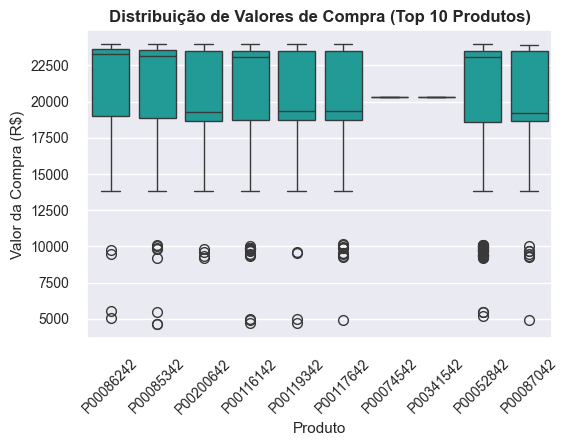

In [31]:
# Filtra e cria uma cópia explícita
top10_produtos_ordenados = ticket_medio_por_produto_top10['produto'].tolist()
df_top10_produtos = df[df['produto'].isin(top10_produtos_ordenados)].copy()

# Converte 'produto' para categoria ordenada
df_top10_produtos['produto'] = pd.Categorical(
    df_top10_produtos['produto'],
    categories=top10_produtos_ordenados,
    ordered=True
)

# Agora o boxplot respeitará a ordem
plotutils.box_plot(
    data=df_top10_produtos,
    x='produto',
    y='valor',
    title='Distribuição de Valores de Compra (Top 10 Produtos)',
    xlabel='Produto',
    ylabel='Valor da Compra (R$)',
    rotation=45
)

### Produto (Bottom10)

In [32]:
#Ticket Médio dos 10 Piores Produtos (ordenado do menor para o maior)
ticket_medio_por_produto_bottom10 = (
    df
    .groupby('produto', observed=False)['valor']
    .mean()
    .astype(int)
    .reset_index()
    .sort_values('valor', ascending=True)
    .head(10)
    .rename(columns={'valor': 'ticket_medio'})
)
ticket_medio_por_produto_bottom10

,produto,ticket_medio
3560,P00370293,36
3565,P00370853,37
3566,P00371644,362
3567,P00372445,374
3568,P00375436,374
891,P00091742,405
406,P00041442,455
2814,P00293442,478
616,P00063242,498
2620,P00273842,524


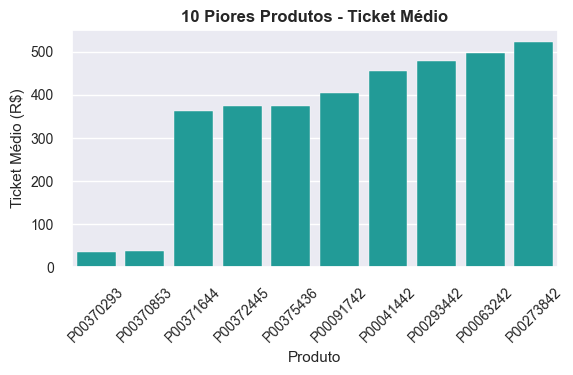

In [33]:
# 2. Gráfico de Barras (Bottom 10 Produtos)
plotutils.bar_plot(
    data=ticket_medio_por_produto_bottom10,
    x='produto',
    y='ticket_medio',
    title='10 Piores Produtos - Ticket Médio',
    xlabel='Produto',
    ylabel='Ticket Médio (R$)',
    rotation=45,
    order=ticket_medio_por_produto_bottom10['produto']  # Ordem crescente
)

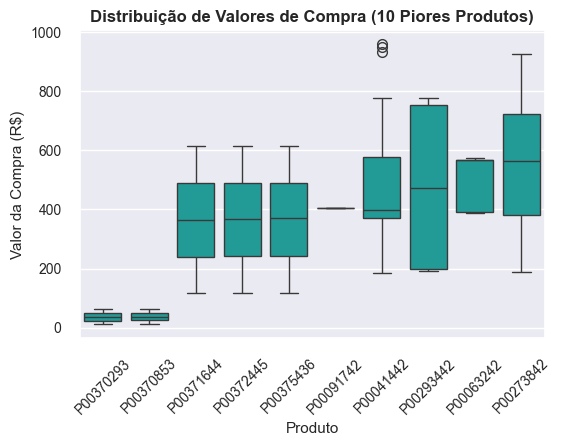

In [34]:
# Prepara o DataFrame filtrado (Bottom 10 produtos)
bottom10_produtos_ordenados = ticket_medio_por_produto_bottom10['produto'].tolist()
df_bottom10_produtos = df[df['produto'].isin(bottom10_produtos_ordenados)].copy()  # Evita SettingWithCopyWarning

# Garante a ordem correta no boxplot (do menor para o maior)
df_bottom10_produtos['produto'] = pd.Categorical(
    df_bottom10_produtos['produto'],
    categories=bottom10_produtos_ordenados,
    ordered=True
)

# 4. Boxplot (Distribuição de valores dos piores produtos)
plotutils.box_plot(
    data=df_bottom10_produtos,
    x='produto',
    y='valor',
    title='Distribuição de Valores de Compra (10 Piores Produtos)',
    xlabel='Produto',
    ylabel='Valor da Compra (R$)',
    rotation=45)

### Categoria do Produto (Top10)

In [35]:
# categoria do produto
ticket_medio_por_categoria_top10 = (
    df
    .groupby('produto_categoria', observed=False)['valor']
    .mean()
    .astype(int)
    .reset_index()
    .sort_values('valor', ascending=False)
    .head(10)
    .rename(columns={'valor': 'ticket_medio'})
)

ticket_medio_por_categoria_top10

,produto_categoria,ticket_medio
9,10,19675
6,7,16365
5,6,15838
8,9,15537
14,15,14780
15,16,14766
0,1,13606
13,14,13141
1,2,11251
16,17,10170


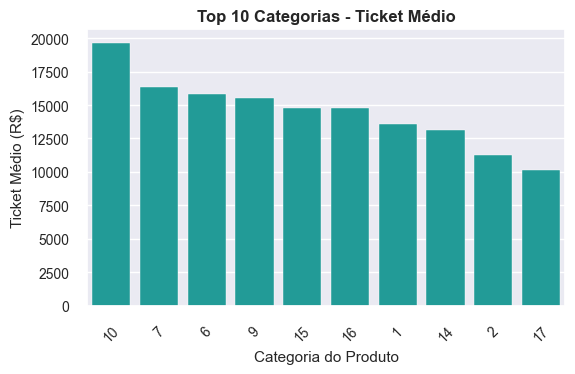

In [36]:
plotutils.bar_plot(
    data=ticket_medio_por_categoria_top10,
    x='produto_categoria',
    y='ticket_medio',
    title='Top 10 Categorias - Ticket Médio',
    xlabel='Categoria do Produto',
    ylabel='Ticket Médio (R$)',
    rotation=45,
    order=ticket_medio_por_categoria_top10['produto_categoria']  # Ordem decrescente
)

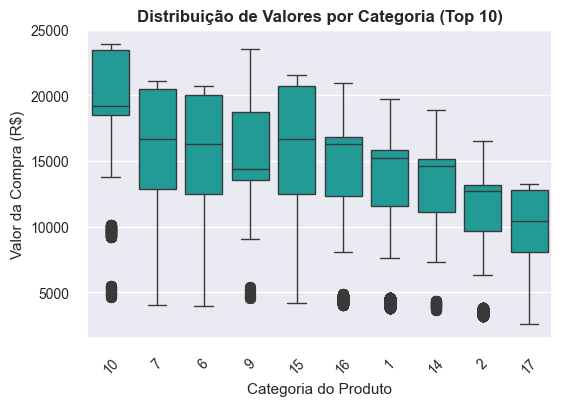

In [37]:
# 3. Prepara o DataFrame filtrado (Top 10 categorias)
top10_categorias_ordenadas = ticket_medio_por_categoria_top10['produto_categoria'].tolist()
df_top10_categorias = df[df['produto_categoria'].isin(top10_categorias_ordenadas)].copy()

# Garante a ordem correta no boxplot
df_top10_categorias['produto_categoria'] = pd.Categorical(
    df_top10_categorias['produto_categoria'],
    categories=top10_categorias_ordenadas,
    ordered=True
)

# 4. Boxplot (Distribuição de valores por categoria)
plotutils.box_plot(
    data=df_top10_categorias,
    x='produto_categoria',
    y='valor',
    title='Distribuição de Valores por Categoria (Top 10)',
    xlabel='Categoria do Produto',
    ylabel='Valor da Compra (R$)',
    rotation=45
)

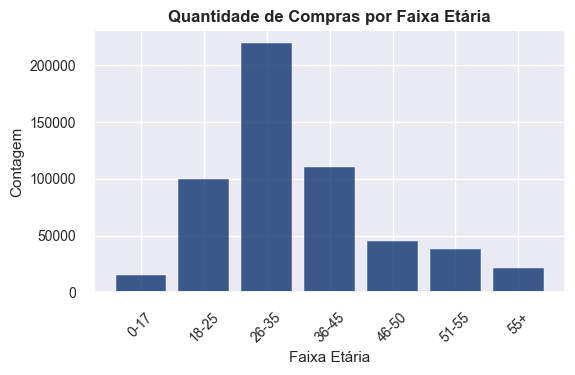

In [38]:
plotutils.hist_plot(
    data=df,
    x='idade',
    title='Quantidade de Compras por Faixa Etária',
    xlabel='Faixa Etária',
    ylabel='Contagem',
    color='#002768',  # Azul escuro conforme seu exemplo
    rotation=45,
    shrink=0.8  # Parâmetro específico para ajustar largura das barras
)

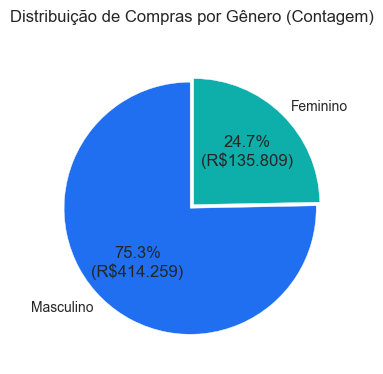

In [39]:
# Genero
contagem_por_genero = (
    df['genero']
    .value_counts()
    .reset_index()
    .rename(columns={'count': 'contagem'})
    .sort_values('contagem', ascending=False)
)
plotutils.pie_chart(
    data=contagem_por_genero.set_index('genero')['contagem'],
    title='Distribuição de Compras por Gênero (Contagem)'
)


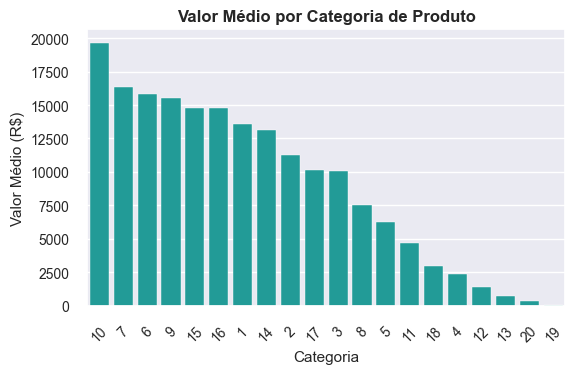

In [40]:
# Frequência de Compras por Categoria de Produto
df_ordenado_por_categoria = (
    df.groupby('produto_categoria', observed=False)['valor']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plotutils.bar_plot(
    data=df_ordenado_por_categoria,
    x='produto_categoria',
    y='valor',
    title='Valor Médio por Categoria de Produto',
    xlabel='Categoria',
    ylabel='Valor Médio (R$)',
    rotation=45,
    order=df_ordenado_por_categoria['produto_categoria']
)

### Análises

1. Estado Civil
- Ticket médio praticamente igual
- Distribuição de valores: Ambos têm comportamentos similares (boxplot sem outliers significativos).
- Conclusão: Estado civil não é um fator decisivo para diferenciação de campanhas.

<br> 

2. Gênero
- Ticket médio maior para homens
- Distribuição de valores: Homens têm média mais alta, mas a dispersão (boxplot) é similar para ambos.
- Mulheres tendem a fazer compras de valor mais modesto
- Homens representam 75% das compras e tem maior variabilidade nos valores das compras e mediana mais elevada
- Conclusão: Público masculino gasta mais em média, mas a diferença não é extremamente significativa. Pode ser interessante testar campanhas segmentadas por gênero.

<br> 

3. Faixa Etária
- Pelo ticket médio não se observou comportamentos radicalmente diferentes. Apresentaram ticket médio de aprox 9 a 9,5 mil, com boxplo muito parecidos.

<br> 

4. Produtos (Top10) 
- Todos os produtos do Top10 têm tickets médios acima de R$20.000.
- Distribuição de valores: Produtos premium apresentam outliers baixos, talvez indicando promoções com descontos pontuais.

<br>

5. Produtos (Bottom10) 
- P00370293 e/ou P00370853 possuem os menores tickets médios (36 e 37) com outliers também consistentemente baixo

<br> 

6. Categorias (Top10)
- A melhor categoria (10) possui ticket médio de R$ 19.675. 
- No top10, 9 estão aentre 10 a 16 mil.
- As categorias 7, 6 e 15 possuem outliers significativamente baixos. Cabe uma oportunidade para investigar os motivos.
- Se uma categoria tem mediana alta, como a 10, isso sugere oportunidade para bundles ou parcelamento longo.
- Outras categorias como a 9, 16, 1, 14 e 2 possuem dispersão menores, sendo mais consistentes

<br>

7. Análise por valores de compra:
- O produto mais vendido é P00265242, que vendeu 1880 unidades
- Assimetria à direita (com a maioria das compras concentrada nos valores mais baixos) e algumas poucas compras com valores significativamente mais altos.
- Esta distribuição condiz com uma típica de dados de varejo, onde a maioria das transações envolve valores modestos, com algumas poucas transações de alto valor.
-  Há uma concentração significativa de compras nos primeiros intervalos de valor (provavelmente entre 1.000-5.000), que depois decai rapidamente conforme o valor aumenta.
- Valores atípicos: A cauda longa à direita sugere a presença de alguns valores atípicos (outliers)

### 3 - Dando continuidade na pesquisa para o próximo ano, favor indicar os top 3 produtos que indicaria para venda no próximo ano, e 1 para riscar da lista. Descreva o racional

- Usando como critério o ticket médio, escolheria um do top 10, já que a diferença entre elas é bem pequena (todos eles acima de 20 mil e desvio padrão muito parecido)
- Para riscar da lista, P00370293 e/ou P00370853 que possuem tickets muito baixo.
- Além do ticket, deve-se levar em consideração outros fatores como: dificuldade e custos com suporte, transporte, estoque, custos, etc e não necessamente o maior ticket signifique maior lucro.

- Durante o processo de resolução do case, realizei algumas análises exploratórias adicionais que me ajudaram a compreender melhor o dataset. Essas investigações trouxeram insights interessantes sobre a distribuição dos dados, relações entre variáveis e padrões comportamentais que, embora relevantes para o entendimento global do problema, não foram diretamente utilizados na resposta final ao case.

- Embora esses achados não tenham sido incorporados à solução final, eles contribuíram significativamente para minha compreensão do contexto dos dados e poderão ser úteis em futuras iterações ou aprofundamentos no projeto.